# Sparkify Project Workspace

## Introduction

This is the final project of my Udacity Nanodegree as Data Scientist. Goal of the project is to predict user churn of an online music streaming service using machine learning algorithms. 

Basis of the project is 12 GB dataset containing all information about user interactions with the online streaming service. The data is stored in a AWS Simple Storage Service (S3) bucket in JSON format.
Datasets of such a large scale are challenging to process on a single computer and can therefore be referred to as big data. 

Apache Spark is a popular tool for large scale data processing and will be used to work with the full dataset. It allows to efficiently spread data and computations across a network of distributed computers, called clusters. Each cluster has nodes (computers) that do the computations in parallel.

It is best practice to explore the data using a smaller subset to reduce necessary computation. This workspace contains a tiny subset (128MB) of the full dataset available. Functions of the Spark SQL library will serve to find features in the data via descriptive statistics. After finding those features in the dataset needed to predict user churn, the next step is to create a supervised machine learning model with Spark ML first based on the small subset and later the full dataset. 

The full dataset will be processed in Amazon Web Services (AWS) with an Elastic Map Reduce (EMR) cluster of 3 m5.xlarge machines. 

The project is structured following CRISP-DM, the Cross Industry Process for Data Mining. These are the steps:

- [1. Business Understanding](#BU)
- [2. Data Understanding](#DU)
- [3. Prepare Data](#prepare)
- [4. Data Modeling](#modeling)
- [5. Evaluate the Results](#evaluate)
- [6. Deploy](#deploy)

### Load libraries, create Spark session and import data 

In [1]:
# import libraries for Spark Session
import pyspark
from pyspark import SparkConf

# import libraries for sql actions
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, IntegerType, DoubleType

# other libraries
import datetime
import time
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Spark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler, StringIndexer, Normalizer, PCA, MinMaxScaler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [172]:
# Set color palette to just one
base_color = sns.color_palette()[0]

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# view information about spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '64878'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'mbp-dark-leo.fritz.box'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1611488883620')]

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [4]:
# define path and load data
path = 'data/mini_sparkify_event_data.json'
user_log = spark.read.json(path)

<a id='BU'></a>
## 1. Business Understanding

Sparkify is a (fictional) music streaming service with a business case similar to Spotify. The service can be used on two levels, free tier or premium tier. Both levels of service generate revenue for Sparkify. The free tier service is financed by advertisement in between the songs, the premium tier consists of a monthly or yearly subscription fee to have an advertisement free experience. 
At any moment the user can decide to downgrade from paid/premium to free, upgrade from free to paid/premium or to cancel from the service completely.
    
Customer churn is when a customer unsubscribes from a service, ceases to purchase a product or stops engaging with a service [[1](https://www.retentionscience.com/blog/why-measuring-your-customer-churn-rate-increases-revenue/)]. In the case of the music streaming service of this project churn will be defined as when a user lands on the 'Cancellation Confirmation' page, which can happen for both paid and free tier users.

Usually it is more expensive for a business to acquire new customers than retaining existing customers. Statistics vary from industry to industry, but research indicates that it may cost up to 5 times more to acquire a new customer than to keep an existing one [[2](https://www.forbes.com/sites/jiawertz/2018/09/12/dont-spend-5-times-more-attracting-new-customers-nurture-the-existing-ones/?sh=36d7a6225a8e)].

To prevent churn candidates special discounts or other costly measures are offered to customers. These measures usually lower the revenue per customer. The goal is to identify users who are about to churn ahead of time and only target them with marketing campaigns. 

Churn prediction is an important classification use case for streaming services such as Netflix, Spotify or Apple Music. Companies that can predict customers who are about to churn ahead of time can implement a more effective customer retention strategy.

<a id='DU'></a>
## 2. Data Understanding

First step is to understand the length of the dataset and the available columns of the data subset (128MB):

In [5]:
# check column names and datatypes of object
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# look at first row
user_log.head(n=1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
# check length of dataset
print('The dataset contains {} rows'.format(user_log.count()))

The dataset contains 286500 rows


#### Column 'artist'

In [8]:
# count unique artists in dataset
unique_artists = user_log.select('artist').dropDuplicates().count()

print('There are {} unique artists in the dataset.'.format(unique_artists))

There are 17656 unique artists in the dataset.


In [9]:
# list artists by occurance
user_log.select(['artist', 'song']).groupby('artist').count().orderBy('count', ascending=False).show(n=8)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
+--------------------+-----+
only showing top 8 rows



The most common value for the artist column in the dataset is 'null'. If the rows containing 'null' as value are valid has to be investigated further.

#### Column 'auth'

In [10]:
# list unique values in authentication column by occurances
user_log.select(['auth', 'userId']).groupby('auth').count().orderBy('count', ascending=False).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [11]:
# look into sample rows of authentication status guest
user_log.filter('auth = "Guest"').select(
    'artist', 'auth', 'firstName', 'method', 'page', 'status', 'userId', 'sessionId').show(n=5)

+------+-----+---------+------+--------+------+------+---------+
|artist| auth|firstName|method|    page|status|userId|sessionId|
+------+-----+---------+------+--------+------+------+---------+
|  null|Guest|     null|   GET|   Error|   404|      |      151|
|  null|Guest|     null|   GET|    Home|   200|      |      151|
|  null|Guest|     null|   GET|Register|   200|      |      151|
|  null|Guest|     null|   GET|    Help|   200|      |      151|
|  null|Guest|     null|   GET|    Home|   200|      |      151|
+------+-----+---------+------+--------+------+------+---------+
only showing top 5 rows



It is possible to interact with Sparkify as a guest. These rows can be dropped, as it is not possible to assign the user interactions of guests to a userId.

In [12]:
# look into sample rows of authentication status guest
user_log.filter('auth = "Cancelled"').select(
    'artist', 'auth', 'firstName', 'method', 'page', 'status', 'userId', 'sessionId').show(n=5)

+------+---------+---------+------+--------------------+------+------+---------+
|artist|     auth|firstName|method|                page|status|userId|sessionId|
+------+---------+---------+------+--------------------+------+------+---------+
|  null|Cancelled|   Adriel|   GET|Cancellation Conf...|   200|    18|      514|
|  null|Cancelled|    Diego|   GET|Cancellation Conf...|   200|    32|      540|
|  null|Cancelled|    Mason|   GET|Cancellation Conf...|   200|   125|      174|
|  null|Cancelled|Alexander|   GET|Cancellation Conf...|   200|   105|      508|
|  null|Cancelled|    Kayla|   GET|Cancellation Conf...|   200|    17|      797|
+------+---------+---------+------+--------------------+------+------+---------+
only showing top 5 rows



The rows with authentication cancelled seem to be valid. It appears as if the authentification status 'cancelled' appears, when a user lands on the 'Cancellation Confirmation' page.

#### Columns 'gender' and 'userId'

In [13]:
# show unique possible values of column 'gender' and occurances
user_log.select(['gender', 'userId']).groupby('gender').count().orderBy('count', ascending=False).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



The table above shows the count of female/male/null entried in ther gender column for all rows. To see how many users are actually of which gender this table has to be filtered to unique userIds. This will help to answer if the dataset is balanced regarding gender.

In [14]:
user_log.select(['gender', 'userId']) \
    .groupby('gender') \
    .agg(F.countDistinct('userId')) \
    .orderBy('count(userId)').show()


+------+-------------+
|gender|count(userId)|
+------+-------------+
|  null|            1|
|     F|          104|
|     M|          121|
+------+-------------+



There are 226 unique userIds (225 valid) in the dataset. 
Of those users 121 are male and 104 are female users. 
There are 0 userId's where the gender is not known
There is only a slight imbalance regarding gender of users. 

#### Columns 'itemInSession', 'sessionId', 'song', 'ts'  and 'length'

In [15]:
# look at behaviour of values in itemInSession for one user as example
user_log.select(['itemInSession', 'userId', 'sessionId', 'ts', 'page', 'song', 'firstName', 'length']) \
    .filter(user_log.userId == "18") \
    .show(n=8)

+-------------+------+---------+-------------+--------+--------------------+---------+---------+
|itemInSession|userId|sessionId|           ts|    page|                song|firstName|   length|
+-------------+------+---------+-------------+--------+--------------------+---------+---------+
|            0|    18|      242|1538499917000|    Home|                null|   Adriel|     null|
|            1|    18|      242|1538499933000|NextSong|A Beggar On A Bea...|   Adriel|275.12118|
|            2|    18|      242|1538500208000|NextSong|...slowdance On T...|   Adriel|268.32934|
|            3|    18|      242|1538500476000|NextSong|       St. Apollonia|   Adriel|178.72934|
|            4|    18|      242|1538500654000|NextSong|      Drunk Stripper|   Adriel|188.76036|
|            5|    18|      242|1538500842000|NextSong|In League With Satan|   Adriel|167.91465|
|            6|    18|      242|1538500856000|Settings|                null|   Adriel|     null|
|            7|    18|      24

The values in column 'itemInSession' counts the interactions which happend for one user during the same sessionId. The value in column 'length' describes the duration of time a song was played and therefore is null for all  page events other than 'NextSong'. The column 'ts' stands for timestamp.

#### Column 'level'

In [16]:
# show unique possible values of column 'level'
user_log.select(['level', 'userId']) \
    .dropDuplicates() \
    .groupby('level').count() \
    .orderBy('count', ascending=False).show()

+-----+-----+
|level|count|
+-----+-----+
| free|  196|
| paid|  166|
+-----+-----+



There are 196 unique userIds of free tier and 166 of paid tier users.

#### Column 'location'

In [17]:
# show unique possible values of column 'location'
user_log.select('userId', 'location') \
    .dropDuplicates() \
    .sort('location').show(n=8, truncate=False)

+------+---------------------------------+
|userId|location                         |
+------+---------------------------------+
|      |null                             |
|100011|Albany, OR                       |
|73    |Albany-Schenectady-Troy, NY      |
|56    |Alexandria, LA                   |
|93    |Allentown-Bethlehem-Easton, PA-NJ|
|83    |Anchorage, AK                    |
|45    |Atlanta-Sandy Springs-Roswell, GA|
|300020|Atlanta-Sandy Springs-Roswell, GA|
+------+---------------------------------+
only showing top 8 rows



In [18]:
# check the highest count of unique locations per userId
user_log.select(['userId', 'location']) \
    .groupby('userId').agg(F.countDistinct('location')) \
    .orderBy('count(location)', ascending=False).show(n=3)

+------+---------------+
|userId|count(location)|
+------+---------------+
|    54|              1|
|    15|              1|
|    51|              1|
+------+---------------+
only showing top 3 rows



In the dataset users always access the streaming service from the same location.

#### Column 'method'

In [19]:
# show unique possible values of column 'method'
user_log.select(['method', 'userId']) \
    .groupby('method').count() \
    .orderBy('count', ascending=False).show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



#### Column 'page'

In [20]:
# show unique possible values of column 'page'
page_events = user_log.select(['page', 'userId']) \
    .groupby('page').count() \
    .withColumnRenamed('count', 'page_event_count') \
    .orderBy('count', ascending=False)

page_events.show(n=30)

+--------------------+----------------+
|                page|page_event_count|
+--------------------+----------------+
|            NextSong|          228108|
|                Home|           14457|
|           Thumbs Up|           12551|
|     Add to Playlist|            6526|
|          Add Friend|            4277|
|         Roll Advert|            3933|
|               Login|            3241|
|              Logout|            3226|
|         Thumbs Down|            2546|
|           Downgrade|            2055|
|                Help|            1726|
|            Settings|            1514|
|               About|             924|
|             Upgrade|             499|
|       Save Settings|             310|
|               Error|             258|
|      Submit Upgrade|             159|
|    Submit Downgrade|              63|
|Cancellation Conf...|              52|
|              Cancel|              52|
|            Register|              18|
| Submit Registration|               5|


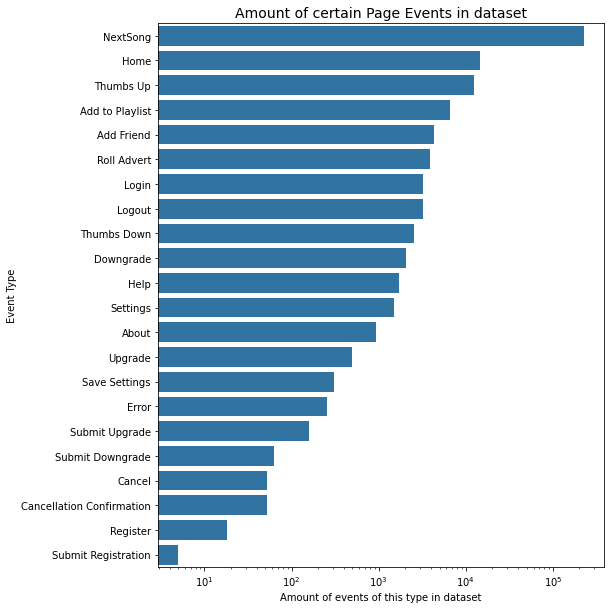

In [175]:
# convert pyspark df to pandas df
page_events_pd = page_events.toPandas()

# plot graph for distribution
plt.figure(figsize=(8,10))
barplot = sns.barplot(x='page_event_count', y='page', data=page_events_pd, color=base_color)
plt.xscale('log')
plt.title('Amount of certain Page Events in dataset', size=14)
plt.xlabel('Amount of events of this type in dataset', size=10)
plt.ylabel('Event Type', size=10)
plt.savefig('events_graphic.png')
plt.show()

The most occured page event is 'NextSong', which is the main function of the streaming service. It seems like the 'NextSong' page get loaded automatically once a song ends. The Home page is the page the user enters when starting a streaming session and the second most common called page event. 

#### Column 'registration'

In [22]:
# look at behaviour of values in the column registration for one user as example
user_log.select(['userId', 'registration']) \
    .groupby('userId') \
    .agg(F.countDistinct('registration')) \
    .orderBy('count(registration)', ascending=False) \
    .show(n=3)

+------+-------------------+
|userId|count(registration)|
+------+-------------------+
|    51|                  1|
|   124|                  1|
|     7|                  1|
+------+-------------------+
only showing top 3 rows



When ordering the amount of registrations per user descending from highest amount per user, it is visible that ther is no userId with more than one registration. Therefore the conclusion is that every userId has exactly one registration.

#### Column 'userAgent'

In [23]:
# show unique possible values of column 'userAgent'
user_log.select('userAgent').dropDuplicates().show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


The column user agent describes the software used to access the streaming service. Examples are Mac OS X with Safari, Windows or Ubuntu.

#### column ts

In [24]:
udf_convert_ts = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(
    timestamp / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

min_ts = user_log.agg({'ts':'min'}) 
max_ts = user_log.agg({'ts':'max'})

min_ts.withColumn('first_date', udf_convert_ts('min(ts)')).show()
max_ts.withColumn('last_date', udf_convert_ts('max(ts)')).show()


+-------------+-------------------+
|      min(ts)|         first_date|
+-------------+-------------------+
|1538352117000|2018-10-01 02:01:57|
+-------------+-------------------+

+-------------+-------------------+
|      max(ts)|          last_date|
+-------------+-------------------+
|1543799476000|2018-12-03 02:11:16|
+-------------+-------------------+



The observed time frame is from 2018-10-01 to 2018-12-03.

<a id='prepare'></a>
## 3. Prepare Data

After getting a Data Understanding, the next step of the CRISP-DM is to prepare the dataset. 
The first step of data preparation in this project is cleaning the data from invalid or missing data - for example, records without userids or sessionids. 
After that an exploratory data analysis will be conducted to find possible features for the customer churn prediction.


### 3.1 Clean Dataset


In [25]:
# change format of timestamp to human readable

udf_convert_ts_to_datetime = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(
    timestamp / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))

udf_convert_ts_to_date = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(
    timestamp / 1000.0).strftime('%Y-%m-%d'))

user_log = user_log.withColumn('datetime', udf_convert_ts_to_datetime(user_log.ts)) \
    .withColumn("date", udf_convert_ts_to_date(user_log.ts))


Drop any row/record where there is no userId or sessionId.

In [26]:
print('The dataset contains {} rows before cleaning'.format(user_log.count()))

# drop any record with NANs in user ID OR session ID and save to new object
user_log_valid = user_log.dropna(how = 'any', subset = ['userId', 'sessionId'])

print('The dataset contains {} rows after dropping any NA value in userId and sessionId'.format(
    user_log_valid.count()))

The dataset contains 286500 rows before cleaning
The dataset contains 286500 rows after dropping any NA value in userId and sessionId


It turns out there are no missing values in the userId or sessionId columns.

In [27]:
# show unique user IDs
user_log.select('userId').dropDuplicates().sort('userId').show(n=5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



There are userId values that are empty strings. These empty userIds appear for example when a user enters the streaming service without logging in.

In [28]:
# drop empty userIds
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

print('The dataset contains {} rows after filtering out empty userIds'.format(
    user_log_valid.count()))

The dataset contains 278154 rows after filtering out empty userIds


In [29]:
# check if guest entries are dropped all
user_log_valid.select(['auth', 'userId']).groupby('auth').count().orderBy('count', ascending=False).show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



In [30]:
# calculate amount of users dropped
amount_users_dropped = user_log.count() - user_log_valid.count()
amount_logged_out = user_log.select('auth').filter('auth = "Logged Out"').count()
amount_guest = user_log.select('auth').filter('auth = "Guest"').count()
amount_rows = user_log_valid.count()

print('{} Rows without userId were dropped. This were the users with authentification status "Logged Out" ({}) \
and "Guest" ({}). Resulting into {} rows in the cleaned dataset.'.format(
    amount_users_dropped, amount_logged_out, amount_guest, amount_rows))

8346 Rows without userId were dropped. This were the users with authentification status "Logged Out" (8249) and "Guest" (97). Resulting into 278154 rows in the cleaned dataset.


### 3.2 Exploratory Data Analysis

Goal of the following exploratory data analysis is to observe differences in the behavior of customers who stayed vs customers who churned. 
One way is to explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Define Churn

First a column 'churned' will be created to use as label to differentiate between customers who churned and those who stayed with the service. 
This column will be used later by the supervised machine learning model as label to train.
The 'Cancellation Confirmation' events serve to define the exact moment of churn, which happens for both paid and free users. 

In [31]:
# show records where Cancellation was confirmed (churn)
user_log_valid.filter("page = 'Cancellation Confirmation'") \
    .select('auth', 'firstName', 'gender', 'itemInSession', 'level', 'location', 'userId') \
    .show(n=5)

+---------+---------+------+-------------+-----+--------------------+------+
|     auth|firstName|gender|itemInSession|level|            location|userId|
+---------+---------+------+-------------+-----+--------------------+------+
|Cancelled|   Adriel|     M|          104| paid|  Kansas City, MO-KS|    18|
|Cancelled|    Diego|     M|           56| paid|Phoenix-Mesa-Scot...|    32|
|Cancelled|    Mason|     M|           10| free|  Corpus Christi, TX|   125|
|Cancelled|Alexander|     M|          332| paid|Indianapolis-Carm...|   105|
|Cancelled|    Kayla|     F|          273| paid|Philadelphia-Camd...|    17|
+---------+---------+------+-------------+-----+--------------------+------+
only showing top 5 rows



In [32]:
# Find users who had event 'Cancellation Confirmation'
user_log_valid.select('userID').where(user_log.page == 'Cancellation Confirmation').show(n=2)

+------+
|userID|
+------+
|    18|
|    32|
+------+
only showing top 2 rows



In [33]:
# inspect example funnel with event 'Cancellation Confirmation' (without most common event NextSong event)
user_log_valid.select(['firstName', 'gender', 'page', 'artist']) \
    .where((user_log_valid.userId == '18') ) \
    .tail(num=8)


[Row(firstName='Adriel', gender='M', page='NextSong', artist='Tonic'),
 Row(firstName='Adriel', gender='M', page='NextSong', artist='Arch Enemy'),
 Row(firstName='Adriel', gender='M', page='NextSong', artist='Les Ogres De Barback'),
 Row(firstName='Adriel', gender='M', page='NextSong', artist='The Notorious B.I.G.'),
 Row(firstName='Adriel', gender='M', page='NextSong', artist='Nickelback'),
 Row(firstName='Adriel', gender='M', page='Downgrade', artist=None),
 Row(firstName='Adriel', gender='M', page='Cancel', artist=None),
 Row(firstName='Adriel', gender='M', page='Cancellation Confirmation', artist=None)]

In [34]:
# user defined function to flag the events page='Cancellation Confirmation' with extra column
flag_cancellation_event = F.udf(
    lambda cancellation_event: 1 if cancellation_event=='Cancellation Confirmation' else 0, IntegerType())

# create extra column 'Cancellation Confirmation'
user_log_valid = user_log_valid.withColumn('cancellation_event', flag_cancellation_event('page'))

In [35]:
# check if column 'cancellation_event' is created correctly
user_log_valid.select(['userId', 'level', 'sessionId', 'page', 'cancellation_event']) \
    .where((user_log_valid.userId == '18') & (user_log_valid.page != 'NextSong')) \
    .tail(num=3)

[Row(userId='18', level='paid', sessionId=514, page='Downgrade', cancellation_event=0),
 Row(userId='18', level='paid', sessionId=514, page='Cancel', cancellation_event=0),
 Row(userId='18', level='paid', sessionId=514, page='Cancellation Confirmation', cancellation_event=1)]

The new column 'cancellation_event' was created to mark the exact event of cancellation confirmation. As the goal of this project is to predict users who eventually churn, it is important to find the features which describe best the differences between users who churn and those who not.
There is another column necessary to compare all user intereactions made by users who eventually churned to users who did not churn. The values of the new column 'churned users' are true if the user will eventually churn and false if not:

In [36]:
# create column with churned users = true
churned_users = user_log_valid.select('userId') \
    .filter(user_log.page == 'Cancellation Confirmation') \
    .dropDuplicates().collect()

userid_churn = []
for i in churned_users:
    userid_churn.append(i[0])
    
user_log_valid = user_log_valid \
    .withColumn('churned',user_log_valid['userId'].isin(userid_churn))

In [37]:
# check if column 'churned' is filled correctly
user_log_valid.select(['userId', 'level', 'page', 'cancellation_event', 'churned']) \
    .where((user_log_valid.userId == '18') & (user_log_valid.page != 'NextSong')) \
    .tail(num=3)

[Row(userId='18', level='paid', page='Downgrade', cancellation_event=0, churned=True),
 Row(userId='18', level='paid', page='Cancel', cancellation_event=0, churned=True),
 Row(userId='18', level='paid', page='Cancellation Confirmation', cancellation_event=1, churned=True)]

With the new column 'churned' it is possible to check, if the dataset it balanced regarding the number of users who eventually churn and those who stay. The churn rate for ther observed period can be calculated.

In [38]:
# check if dataset is balanced regarding churned users
users = user_log_valid.select('userId').dropDuplicates().count()
churned_users = user_log_valid.filter('churned = True').select('userId').dropDuplicates().count()
stayed_users = user_log_valid.filter('churned = False').select('userId').dropDuplicates().count()

print('Of total {} users, {} users stayed with the streaming service during the observed time and \
{} users eventually churned (churn rate: {:2.2f}% ).'.format(users, stayed_users, churned_users, 
                                                         churned_users/users*100))

Of total 225 users, 173 users stayed with the streaming service during the observed time and 52 users eventually churned (churn rate: 23.11% ).


There is a imbalance in the dataset regarding the amount of users who churned versus those who stayed. Next step is to check how this imbalance in amount of users scales on the amount of interactions.

In [39]:
user_interactions = user_log_valid.count()
churned_users_interactions = user_log_valid.filter('churned = True').count()
stayed_users_interactions = user_log_valid.filter('churned = False').count()

print('Of total {} user interactions, {} user interactions were recorderd of useres who stayed with the \
streaming service during the observed timer and {} user interactions were recorded of users who eventually \
churned ({:2.2f}% of user interaction are by churned customers).'.format(user_interactions, churned_users_interactions, stayed_users_interactions,
                                    churned_users_interactions/user_interactions*100))

Of total 278154 user interactions, 44864 user interactions were recorderd of useres who stayed with the streaming service during the observed timer and 233290 user interactions were recorded of users who eventually churned (16.13% of user interaction are by churned customers).


The amount of data available regarding interactions to analyze the difference in behaviour for users who stayed versus users who churned is clearly imbalanced. 

Imbalance in the training data can lead to naive behaviour in the prediction of the supervised machine learning model. With 76.89% of users not churning a prediction accuracy of 76.89% can be achieved by simply always predicting 'no churn' [3](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28).

There are different ways to handle imbalanced data before feeding it to machine learning algorithms. 
One way would be to manipulate the input data by eiter undersampling data of loyal users, oversampling the data of churned users or generating synthetic data.
In this project the way to handle the imbalance in data of interaction with the service by churned users will be creating additional features.

#### Calculate days since registration

In [40]:
# calculate total number of days since registration
user_log_valid = user_log_valid.withColumn('days_since_registration', F.ceil(
    (user_log_valid.ts - user_log_valid.registration)/(1000*60*60*24)))

#### Calculating Statistics by Hour

In the next few cells will be calculated if there amount of songs played by users differs during the hours of a day:

In [41]:
# create user defined function to convert the ts column into hour format
get_hour = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0). hour)

# create new column "hour" by applying udf get_hour
user_log_valid = user_log_valid.withColumn('hour', get_hour(user_log_valid.ts))

# take only amount of action "NextSong" and group it by hour of day
songs_in_hour = user_log_valid.filter(user_log_valid.page == 'NextSong').groupby(
    'hour').count().orderBy(user_log_valid.hour.cast('float'))

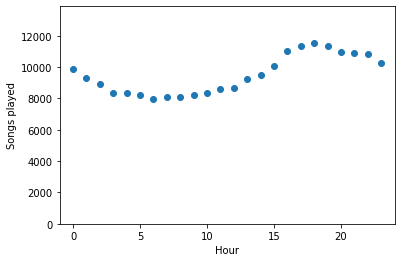

In [42]:
# convert spark object ot pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

# plot the amount of songs played over hours of day
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel('Songs played');

#### Total Amount of Page Events per UserId

How many page events happen per userId for the observed time period in total comparing churned with loyal users.

In [43]:
# total amount of page events per userId
page_event_per_user = user_log_valid.select('page','userId', 'churned') \
    .groupby('userId', 'churned').count() \
    .withColumnRenamed('count', 'total_page_events') \

page_event_per_user.orderBy('total_page_events', ascending=False).show(n=5)

+------+-------+-----------------+
|userId|churned|total_page_events|
+------+-------+-----------------+
|    39|  false|             9632|
|    92|  false|             7230|
|   140|  false|             6880|
|300011|  false|             5732|
|   124|  false|             4825|
+------+-------+-----------------+
only showing top 5 rows



In [44]:
# mean of page events per user
page_event_per_user.groupby('churned').mean().show()

+-------+----------------------+
|churned|avg(total_page_events)|
+-------+----------------------+
|   true|     862.7692307692307|
|  false|    1348.4971098265896|
+-------+----------------------+



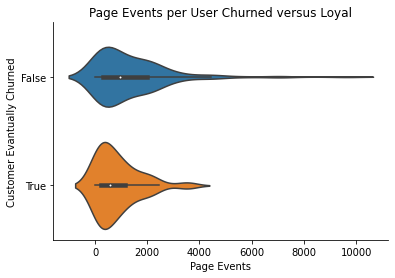

In [45]:
# convert spark object to pandas dataframe
page_event_per_user_pd = page_event_per_user.toPandas()

# Plot
ax = sns.violinplot(data=page_event_per_user_pd, y='churned', x='total_page_events', orient='h')
plt.xlabel('Page Events')
plt.ylabel('Customer Evantually Churned')
plt.title('Page Events per User Churned versus Loyal')
sns.despine(ax=ax);


Comparing users who churned with those who stayed, there is clearly a difference in mean page events per user. It seems plausible that, in average, users who do not churn might stay longer with the service and therfore as well have more page events. 
More interesting would be if users have more page events per time period.
In the following cells will be investigated if there is a difference in page events per session as well. 

#### Functions to create Features 

In [96]:
def create_statistic_per_userId_streamingTime(pyspark_df, event_type):
    '''
    Function to calculate amount of certain events per userId.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        event - (string) page event
    return:
    '''
    streaming_time_df = pyspark_df.filter(pyspark_df.page == 'NextSong') \
        .groupBy('userId', 'churned') \
        .agg((F.sum('length')/3600).alias('streamingTime_h'))
        #(F.count('length').alias('streamingTime_h')))
        #

    event_statistics_df = pyspark_df.filter(pyspark_df.page == event_type) \
        .groupBy('userId') \
        .agg(F.count('userId').alias(event_type))

    feature_df = streaming_time_df.join(event_statistics_df, on=['userId'], how='inner')

    feature_df = feature_df.withColumn(
        event_type+'_per_streamingTime', feature_df[event_type]/feature_df.streamingTime_h)

    return feature_df

In [ ]:
def plot_events_per_userStreaming(feature_pyspark_df, event_type):
    '''
    Function to create boxplot of pyspark dataframe created with 'count_events_per_user' function.
    
    args:
        count_pysparkdf - (pyspark dataframe) created with 'count_events_per_user'
        event - (string) page event
    
    return:
    '''
    feature_pyspark_pd = feature_pyspark_df.toPandas()
    
    ax = sns.violinplot(data=feature_pyspark_pd, y='churned', x=event_type, orient='h')
    plt.xlabel(event_type + ' per UserId')
    plt.ylabel('Customers Churned')
    plt.title(event_type + ' per UserId per StreamingTime churned/not churned')
    sns.despine(ax=ax);
    
    return 

In [ ]:
def plot_events_per_user(feature_pyspark_df, event_type):
    '''
    Function to create boxplot of pyspark dataframe created with 'count_events_per_user' function.
    
    args:
        count_pysparkdf - (pyspark dataframe) created with 'count_events_per_user'
        event - (string) page event
    
    return:
    '''
    feature_pyspark_pd = feature_pyspark_df.toPandas()
    
    ax = sns.violinplot(data=feature_pyspark_pd, y='churned', x=event_type, orient='h')
    plt.xlabel(event_type)
    plt.ylabel('Customers Churned')
    plt.title(event_type + ' per UserId churned/not churned')
    sns.despine(ax=ax);
    
    return 

In [ ]:
def calculate_avg_events_lastXsessions(pyspark_df, amount_sessions):
    '''
    Function to calculate mean of all events per userId for last x sessionIds.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        amount_sessions - amount of last sessions from which mean is calculated
        event_type - (string) page event
    return:
    '''
    
    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('max(ts)')) 

    pyspark_df = pyspark_df.select('userId', 'churned', 'sessionId', 'page', 'ts') \
        .groupBy('userId', 'churned', 'sessionId') \
        .agg(F.max('ts'), F.count('page')) \
        .withColumn('session_number', F.row_number().over(user_window))
    
    pyspark_df = pyspark_df.filter(pyspark_df.session_number <= amount_sessions) \
        .groupBy('userId', 'churned') \
        .agg(F.avg('count(page)')) \
        .withColumnRenamed('avg(count(page))', 'average_amount_songs_lastXsessions')
    
    return pyspark_df

def find_optimal_amount_sessions_for_max_diff(pySpark_df):
    '''
    Function to find amount of sessions with highest difference in mean.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        event_type - (string) page event
    return:
    '''
    for i in range(1,10):
        avg_amount_songs_lastXsessions = calculate_avg_events_lastXsessions(pySpark_df, i)

        diff_pd = avg_amount_songs_lastXsessions.groupBy('churned').mean() \
            .select('avg(average_amount_songs_lastXsessions)').toPandas()

        print('Difference in average events for last {} sessions is {}'.format(
            i, diff_pd.values[1][0] - diff_pd.values[0][0]))
          

In [ ]:
def calculate_avg_page_event_lastXsessions(pyspark_df, amount_sessions, event_type):
    '''
    Function to calculate mean of certain events per userId for last x sessionIds.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        amount_sessions - amount of last sessions from which mean is calculated
        event_type - (string) page event
    return:
    '''
    
    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('max(ts)')) 

    pyspark_df = pyspark_df.select('userId', 'churned', 'sessionId', 'page', 'ts') \
        .filter(pyspark_df.page == event_type) \
        .groupBy('userId', 'churned', 'sessionId') \
        .agg(F.max('ts'), F.count('page')) \
        .withColumn('session_number', F.row_number().over(user_window))
    
    pyspark_df = pyspark_df.filter(pyspark_df.session_number <= amount_sessions) \
        .groupBy('userId', 'churned') \
        .agg(F.avg('count(page)')) \
        .withColumnRenamed('avg(count(page))', 'average_amount_songs_lastXsessions')
    
    return pyspark_df


In [ ]:
def find_amount_sessions_for_max_diff(pySpark_df, event_type):
    '''
    Function to find amount of sessions with highest difference in mean.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        event_type - (string) page event
    return:
    '''
    for i in range(1,10):
        avg_amount_songs_lastXsessions = calculate_avg_page_event_lastXsessions(pySpark_df, i, event_type)

        diff_pd = avg_amount_songs_lastXsessions.groupBy('churned').mean() \
            .select('avg(average_amount_songs_lastXsessions)').toPandas()

        print('Difference in average {} events for last {} sessions is {}'.format(
            event_type, i, diff_pd.values[1][0] - diff_pd.values[0][0]))
          

#### Thumbs Up Events per UserId per StreamingTime

In [ ]:
# calculate events per user and streaming time
thumbsUp_per_streamingTime = create_statistic_per_userId_streamingTime(user_log_valid, 'Thumbs Up')

# show table with mean of churned/stayed
thumbsUp_per_streamingTime.groupBy('churned').mean() \
    .select('churned', 'avg(Thumbs Up_per_streamingTime)').show()

# create plot 
plot_events_per_userStreaming(thumbsUp_per_streamingTime, 'Thumbs Up')

Users who eventually churn give in average 37.18 Thumbs Up during usage of the service, users who stay with the service 62.98. To eliminate the influence of average longer registration duration for customers who did not churn, the graphic above shows Thumbs Up Events per UserIs per total streaming time of the user. There is only a slight difference in mean.

#### Thumbs Down Events per UserId per StreamingTime

In [ ]:
# calculate events per user and streaming time
thumbsDown_per_streamingTime = create_statistic_per_userId_streamingTime(user_log_valid, 'Thumbs Down')

# show table with mean of churned/stayed
thumbsDown_per_streamingTime.groupBy('churned').mean() \
    .select('churned', 'avg(Thumbs Down_per_streamingTime)').show()

# create plot 
plot_events_per_userStreaming(thumbsDown_per_streamingTime, 'Thumbs Down')

The graphic above shows Thumbs Down Events per UserIs per total streaming time of the user. The difference in mean of Thumbs Down Events is higher than for Thumbs Up Events.

#### Roll Advert Events per UserId per StreamingTime

In [ ]:
# calculate events per user and streaming time
rollAdvert_per_streamingTime = create_statistic_per_userId_streamingTime(user_log_valid, 'Roll Advert')

# show table with mean of churned/stayed
rollAdvert_per_streamingTime.groupBy('churned').mean() \
    .select('churned', 'avg(Roll Advert_per_streamingTime)').show()

# create plot 
plot_events_per_userStreaming(rollAdvert_per_streamingTime, 'Roll Advert')

In the dataset analyzed the average amount of adverts users experience is significantly higher for those who eventually churn, than for those who stay with the service. It is possible that this is due to a higher percentage of users using the free tier among those who churn.

In [ ]:
user_log_valid.groupBy('churned','level') \
    .agg(F.count('userId')).show()

In [ ]:
print('There are {:2.2f}% free tier users among those who churned and {:2.2f}% free tier users among those who \
    stayed'.format(12388/(32476+12388)*100,43333/(189957+43333)*100))

#### Downgrade Events per UserId per StreamingTime

In [ ]:
# calculate events per user and streaming time
downgrade_per_streamingTime = create_statistic_per_userId_streamingTime(user_log_valid, 'Downgrade')

# show table with mean of churned/stayed
downgrade_per_streamingTime.groupBy('churned').mean() \
    .select('churned', 'avg(Downgrade_per_streamingTime)').show()

# create plot 
plot_events_per_userStreaming(downgrade_per_streamingTime, 'Downgrade')

There is a small difference in mean amount of Downgrade Page visits among User who churned versus not chunred relative to the his/her total streaming time.

#### Downgrades per UserId in last x sessions

In [ ]:
# find amount of sessions with highest difference in mean
find_amount_sessions_for_max_diff(user_log_valid, 'Downgrade')

In [ ]:
# average songs played for the last three sessionIds per userId

avg_amount_songs_lastXsessions = calculate_avg_page_event_lastXsessions(user_log_valid, 3, 'Downgrade')

avg_amount_songs_lastXsessions.groupBy('churned').mean().show()

plot_events_per_user(avg_amount_songs_lastXsessions, 'average_amount_songs_lastXsessions')

Now comparing the average amount of Downgrade events in the last observed sessionId for users who churned versus users who did stay with the service, the results seem more intuitive. Still, it is not clear if this feature helps to predict users who eventually churn.

#### Number of days from registration date to last observed event

In [ ]:
# log entry with max amount days since registration
days_since_registration = user_log_valid.groupBy('userId', 'churned') \
        .agg(F.max('days_since_registration').alias('days_since_registration'))

In [ ]:
# compare difference in mean
days_since_registration.groupBy('churned').mean().show()

# convert to pandas df to plot
days_since_registration_pd = days_since_registration.toPandas()

# plot
ax = sns.violinplot(data=days_since_registration_pd, y='churned', x='days_since_registration', orient='h')
plt.xlabel('Number of days from registration date to last observed event')
plt.ylabel('Customers Churned')
plt.title('Number of days from registration date to last observed event churned/not churned')
sns.despine(ax=ax);

There is a significant difference in registration duration comparing churned customers with those who stayed with the service. The mean duration from registration to last interaction with the streaming service is 57.8 days for users who eventually churn and 87.1 days for users who stay with the service. Therefore the time passed since a user registered to the streaming service is feature that can be useful to predict users who are prone to churn. There are some outliers visible where churned is false, these are the users who registered to the streaming service and stopped using it without cancelling the service.
The observed time period is about 2 months.
A user could be inactive for two month and use the service again.
Therefore in this analysis those users who are just inactivte, but do not cancel from the service, will be defined as not churned.

#### Average amount songs played between visiting home

In [ ]:
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

udf_homevisit = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

songs_per_homevisit = user_log_valid.filter((user_log_valid.page == "NextSong") | (user_log_valid.page == 'Home')) \
    .select('userID', 'churned', 'page', 'ts') \
    .withColumn('homevisit', udf_homevisit(F.col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

songs_per_homevisit = songs_per_homevisit.filter((songs_per_homevisit.page == 'NextSong')) \
    .groupBy('userID', 'churned', 'period') \
    .agg({'period':'count'}) \
    .groupBy('userID', 'churned').mean() \
    .withColumnRenamed('avg(count(period))', 'avg_songs_between_home') \
    .select('userID', 'churned', 'avg_songs_between_home')


songs_per_homevisit.groupBy('churned') \
    .agg({'avg_songs_between_home':'avg'}).show()

In [ ]:
# show lowest values of average songs between home visit for userIds
songs_per_homevisit.orderBy('avg_songs_between_home', ascending=True).show(n=8)

In [ ]:
# convert spark object ot pandas dataframe
songs_per_homevisit_pd = songs_per_homevisit.toPandas()

# Plot
ax = sns.violinplot(data=songs_per_homevisit_pd, y='churned', x='avg_songs_between_home', orient='h')
plt.xlabel('Average amount of songs played between visiting the Home Page')
plt.ylabel('Customer Evantually Churned')
plt.title('Average Amount Songs played per userId between visiting Home Page')
sns.despine(ax=ax);

Users who evantually churned did in average play about two songs less between visiting the Home page than users who stayed with the service. Churned users played in average 20.16 songs between visiting the Home page, loyal users played in average 22.316 songs.

#### Average Amount Songs played per Session

In [ ]:
avg_amount_songs_played_per_session = user_log_valid.select('userId', 'sessionId', 'churned', 'page') \
    .filter('page = "NextSong"') \
    .groupby('userId', 'sessionId', 'churned').count() \
    .select('userId', 'churned', 'count') \
    .groupby('userId', 'churned').mean() \
    .withColumnRenamed('avg(count)', 'avg_amount_songs_played_per_session') \

avg_amount_songs_played_per_session.groupBy('churned').mean().show()

plot_events_per_user(avg_amount_songs_played_per_session, 'avg_amount_songs_played_per_session')

#### Page Events per SessionId per UserId

In [ ]:
find_optimal_amount_sessions_for_max_diff(user_log_valid)

In [ ]:
# average songs played for the last three sessionIds per userId

avg_amount_songs_lastXsessions = calculate_avg_events_lastXsessions(user_log_valid, 3)

avg_amount_songs_lastXsessions.groupBy('churned').mean().show()

plot_events_per_user(avg_amount_songs_lastXsessions, 'average_amount_songs_lastXsessions')

#### Average amount songs played in last x sessions


In [ ]:
# count sessionIds per userId

user_log_valid.select('userId', 'sessionId') \
    .groupBy('userId').count() \
    .orderBy('count') \
    .show(n=5)

There is no user in the dataset with less than 6 sessions.
Next step is to define a function to reuse for calculating average occurances of certain events for a defined amount of sessions per user.

In [ ]:
# find amount of sessions with highest difference in mean
find_amount_sessions_for_max_diff(user_log_valid, 'NextSong')

The difference in average songs played comparing churned users with those who stayed is maximal when taking the average songs played for the last three sessionIds.

In [ ]:
# average songs played for the last three sessionIds per userId

avg_amount_songs_lastXsessions = calculate_avg_page_event_lastXsessions(user_log_valid, 3, 'NextSong')

avg_amount_songs_lastXsessions.groupBy('churned').mean().show()

plot_events_per_user(avg_amount_songs_lastXsessions, 'average_amount_songs_lastXsessions')

#### Percentage of days since registration where user was active

In [ ]:
activity_df = user_log_valid.groupBy('userId', 'churned') \
    .agg(F.max('days_since_registration').alias('days_since_registration'), 
         F.countDistinct('date').alias('days_active'))

activity_df = activity_df.filter('days_since_registration >= 1')
    
activity_df = activity_df \
    .withColumn('percentage_active_days', activity_df.days_active/activity_df.days_since_registration)

In [ ]:
# compare difference in mean
activity_df.groupBy('churned').mean().show()

# convert to pandas df to plot
activity_pd = activity_df.toPandas()

# plot
ax = sns.violinplot(data=activity_pd, y='churned', x='percentage_active_days', orient='h')
plt.xlabel('Percentage of days since registration where user was active')
plt.ylabel('Customers Churned')
plt.title('Percentage of days since registration where user was active churned/not churned')
sns.despine(ax=ax);

#### Streaming time per active day

In [ ]:
streaming_df = user_log_valid.filter(user_log_valid.page == 'NextSong') \
    .groupBy('userId', 'churned') \
    .agg((F.sum('length')/3600).alias('streamingTime_h'),
         F.countDistinct('date').alias('days_active'))
    
streaming_df = streaming_df \
    .withColumn('streaming_per_active_day', streaming_df.streamingTime_h/streaming_df.days_active)

In [186]:
# compare difference in mean
streaming_df.groupBy('churned').mean().show()

# convert to pandas df to plot
streaming_pd = streaming_df.toPandas()

# plot
ax = sns.violinplot(data=streaming_pd, y='churned', x='streaming_per_active_day', orient='h')
plt.xlabel('Streaming hours per active day')
plt.ylabel('Customers Churned')
plt.title('Streaming hours per active day churned/not churned')
sns.despine(ax=ax);

NameError: name 'streaming_df' is not defined

### 3.3 Feature Creation

After exploring possible features for a prediction model, the next step is to select the features which should be used for the machine learning model to decide if a user will churn or not.
If the model will be based on algorithms like Logistic Regression or Linear Regression, the features have to be checked for Multicollinearity. 
When the features have high correlation and one feature can be predicted from other features there might be Multicollinearity. This can lead to misleading results in the prediction of the label. 
Decision trees and boosted trees algorithms are immune to multicollinearity. When they decide to split, the tree will choose only one of the perfectly correlated features.
 [3](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4)

In [49]:
# function to clean dataframe

def clean_dataset(user_log_df):
    '''
    Function to clean user_log datase from userIds and sessionIds from NA and empty values.
    '''

    user_log_clean_df = user_log_df.dropna(how = 'any', subset = ['userId', 'sessionId'])
    user_log_clean_df = user_log_clean_df.filter(user_log_clean_df['userId'] != '')

    print('The dataset originally contained {} rows. \nAfter cleaning there are {} rows left.'
          .format(user_log_df.count(), user_log_clean_df.count()))
    
    return user_log_clean_df

In [50]:
# create labeled dataframe

def create_churn_label(user_log_clean_df):
    '''
    Function to create dataframe with numeric labels for churn, gender and level per userId from user_log.
    '''
    
    user_log_flagged_df = flag_cancellation_events(user_log_clean_df)
    labeled_data = create_labeled_userIds(user_log_flagged_df)
    
    return labeled_data
     
    
def flag_cancellation_events(user_log_clean_df):
    '''
    Function to create new column in user_log where cancellation events are lagged with 1.
    '''
    
    flag_cancellation_event = F.udf(
        lambda cancellation_event: 1 if cancellation_event=='Cancellation Confirmation' else 0, IntegerType())
    
    user_log_flagged_df = user_log_clean_df.withColumn('cancellation_event', flag_cancellation_event('page'))

    return user_log_flagged_df


def create_labeled_userIds(user_log_flagged_df):
    '''
    Function to convert user_log to dataframe with one line per userId.
    '''
    
    window_timeOrdered = Window.partitionBy('userId').orderBy(F.desc('ts'), F.desc('itemInSession'))
    user_log_flagged_df = user_log_flagged_df.withColumn('rank', F.rank().over(window_timeOrdered))
    labeled_df = user_log_flagged_df.select('userId', 'cancellation_event', 'gender', 'level') \
        .filter(user_log_flagged_df.rank == 1)
    
    labeled_df = labeled_df.withColumnRenamed('cancellation_event', 'label')
    
    return labeled_df
    
    
def convert_to_numeric(labeled_data, categegorical_column):  
    '''
    Function to convert a categorical dataframe to a numerical dataframe.
    '''
    
    indexer = StringIndexer(inputCol=categegorical_column, outputCol=categegorical_column+'Numeric')
    indexed_df = indexer.fit(labeled_data).transform(labeled_data).drop(categegorical_column)

    return indexed_df



In [125]:
# create features dataframe

def create_features(user_log_clean):
    '''
    Function to create features for ML model to predict churn.
    '''
    feature_df = create_features_per_songs_played(user_log_clean)
    days_registrated = calculate_days_since_registrations(user_log_clean)  
    songs_per_homevisit = calculate_songs_per_homevisit(user_log_clean)    
    activity = calculate_activity(user_log_clean)   
    streaming_h_per_activeDay = calculate_streaming_per_active_day(user_log_clean)  
    
    feature_df = feature_df.join(days_registrated, on=['userId'], how='full') \
        .join(songs_per_homevisit, on=['userId'], how='full') \
        .join(streaming_h_per_activeDay, on=['userId'], how='full') \
        .join(activity, on=['userId'], how='full') 

    feature_df = feature_df.na.fill(0)
    
    return feature_df


def create_features_per_songs_played(user_log_clean):
    '''
    Function to create all columns with events per songs_played
    '''
    home_per_songs_played = calculate_event_per_songs_played(user_log_clean, 'Home')
    feature_df = home_per_songs_played
    
    events = ['Thumbs Up', 'Add to Playlist', 'Add Friend', 'Roll Advert', 'Thumbs Down', 
              'Downgrade', 'Help', 'About', 'Upgrade', 'Error',  'Submit Upgrade', 'Submit Downgrade']
    
    for event in events:
        new_feature = calculate_event_per_songs_played(user_log_clean, event)
        feature_df = feature_df.join(new_feature, on=['userId'], how='full') 
    
    return feature_df
    

def calculate_event_per_songs_played(user_log_clean, event_type):
    '''
    Function to calculate amount of certain events per userId.
    '''
    event_name = event_type.replace(' ', '_')
    
    songs_played_df = user_log_clean.filter(user_log_clean.page == 'NextSong') \
        .groupBy('userId').agg(F.count('userId').alias('songs_played'))

    event_statistics_df = user_log_clean.filter(user_log_clean.page == event_type) \
        .groupBy('userId').agg(F.count('userId').alias(event_type))

    print('{}: {}'.format(event_type, event_statistics_df.count()))
    
    feature_df = songs_played_df.join(event_statistics_df, on=['userId'], how='full')
    
    
    feature_df = feature_df.withColumn(
        event_name+'_per_songs_played', feature_df[event_type]/feature_df.songs_played) \
        .drop(event_type, 'songs_played')

    return feature_df


def calculate_avg_event_lastXsessions(user_log_clean, amount_sessions, event_type):
    '''
    Function to calculate mean of certain events per userId for last x sessionIds.
    '''
    
    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('max(ts)')) 

    user_log_clean = user_log_clean.select('userId', 'sessionId', 'page', 'ts') \
        .filter(user_log_clean.page == event_type) \
        .groupBy('userId', 'sessionId') \
        .agg(F.max('ts'), F.count('page')) \
        .withColumn('session_number', F.row_number().over(user_window))
    
    avg_event_lastXsessions = user_log_clean.filter(user_log_clean.session_number <= amount_sessions) \
        .groupBy('userId') \
        .agg(F.avg('count(page)')) \
        .withColumnRenamed('avg(count(page))', 'avg_'+event_type+'_lastXsessions')
    
    return avg_event_lastXsessions


def calculate_days_since_registrations(user_log_clean):
    '''
    Function to create a dataframe with days since registration per userId
    '''
    
    user_log_clean = add_days_since_registration(user_log_clean)
    
    days_registrated = user_log_clean.groupBy('userId') \
        .agg(F.max('days_since_registration').alias('days_registrated'))
    
    return days_registrated


def add_days_since_registration(user_log_clean):
    '''
    Function to add column with days since registration for each user
    '''
    user_log_clean = user_log_clean.withColumn('days_since_registration', (F.ceil(
        (user_log_clean.ts - user_log_clean.registration)/(1000*60*60*24)).cast('double'))) 
    
    return user_log_clean


def calculate_songs_per_homevisit(user_log_clean):
    '''
    Function to create dataframe with mean amount of songs between two home visits'''
    
    udf_homevisit = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())

    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)

    songs_per_homevisit = user_log_clean.filter((user_log_clean.page == "NextSong") | (user_log_clean.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', udf_homevisit(F.col('page'))) \
        .withColumn('period', F.sum('homevisit').over(user_window))

    songs_per_homevisit = songs_per_homevisit.filter((songs_per_homevisit.page == 'NextSong')) \
        .groupBy('userID', 'period') \
        .agg({'period':'count'}) \
        .groupBy('userID').mean() \
        .withColumnRenamed('avg(count(period))', 'songs_per_homevisit') \
        .drop('avg(period)')
    
    return songs_per_homevisit


def calculate_avg_songs_per_session(user_log_clean):
    '''
    Function to create dataframe with mean amount of songs played per session for each user.
    '''
    avg_amount_songs_played_per_session = user_log_clean.select('userId', 'sessionId', 'page') \
        .filter('page = "NextSong"') \
        .groupby('userId', 'sessionId').count() \
        .select('userId', 'count') \
        .groupby('userId').mean() \
        .withColumnRenamed('avg(count)', 'avg_songs_per_session') \
    
    return avg_amount_songs_played_per_session


def calculate_activity(user_log_clean):

    user_log_clean = add_days_since_registration(user_log_clean)
    
    user_log_clean = create_date_column(user_log_clean)

    activity_df = user_log_clean.groupBy('userId') \
        .agg(F.max('days_since_registration').alias('days_since_registration'), 
             F.countDistinct('date').alias('days_active'))

    activity_df = activity_df.filter('days_since_registration >= 1')
    
    activity_df = activity_df \
        .withColumn('percentage_active_days', activity_df.days_active/activity_df.days_since_registration) \
        .drop('days_since_registration', 'days_active')
    
    return activity_df


def create_date_column(user_log_clean):
    '''
    Function to change format of timestamp to human readable format.
    '''
    
    udf_convert_ts_to_date = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(
        timestamp / 1000.0).strftime('%Y-%m-%d'))

    user_log_clean = user_log_clean \
        .withColumn('date', udf_convert_ts_to_date(user_log.ts))
    
    return user_log_clean


def calculate_streaming_per_active_day(user_log_clean):
    '''
    Function to create a dataframe contatining a column with hours of streaming per active day
    '''
    user_log_clean = create_date_column(user_log_clean)
    
    streaming_df = user_log_clean.filter(user_log_clean.page == 'NextSong') \
        .groupBy('userId') \
        .agg((F.sum('length')/3600).alias('streamingTime_h'),
             F.countDistinct('date').alias('days_active'))
    
    streaming_df = streaming_df \
        .withColumn('streaming_per_active_day', streaming_df.streamingTime_h/streaming_df.days_active) \
        .drop('streamingTime_h', 'days_active')
    
    return streaming_df

In [126]:
def label_data(feature_df, labeled_df):
    '''
    Function to label users as churned/not churned
    '''
    data_df = feature_df.join(labeled_df, on=['userId'], how='inner') 
    
    return data_df

In [127]:
def create_correlation_graphic(data_raw):
    '''
    Function to visualize correlation of features.
    '''

    data_pd = data_raw.toPandas()
    corrMatrix = data_pd.corr()

    mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))

    cmap = sns.diverging_palette(240, 20, n=10)
    plt.figure(figsize=(18,18))
    sns.heatmap(corrMatrix, annot=True, cmap=cmap, mask=mask)
    plt.title('Correlation Matrix For Created Features')
    plt.savefig('correlation_graphic.png')
    plt.show()

## 4. Data Modeling


### 4.1 Vector Assembler and Feature Scaling

Combine created features into a single vector and scale them usign Normalizer or Standard Scaler.

In [131]:
def find_numerical_columns(data_raw):
    '''
    Function to create array with column names of numeric columns
    
    args:
        data_raw (spark dataframe): dataframe containing the features one column per feature for every userId
        
    returns:
        numerical_columns (array): array containing the names of the numerical columns
    '''
    
    numerical_columns = [f.name for f in data_raw.schema.fields if isinstance(f.dataType, (DoubleType))]
    
    return numerical_columns

In [182]:
def create_preprocessing_pipeline(data_raw):
    '''
    Function to create a preprocessing pipeline for a given datafrane
    
    args:
        data_raw (spark dataframe): dataframe containing the features one column per feature for every userId
        
    returns:
        preprocess_pipeline (pyspark pipeline): a pipeline to process numerical and categorical featues into a feature vector
        
    '''

    # differentiate between numerical and categorical columns
    numerical_columns = find_numerical_columns(data_raw)

    # index categorical columns
    indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_indexed')
    indexer_level = StringIndexer(inputCol='level', outputCol='level_indexed')
    assembler_categorical = VectorAssembler(inputCols = ['gender_indexed', 'level_indexed'],
                                        outputCol = 'categorical_vectorized')

    # assemble and scale numerical columns
    assembler_numerical = VectorAssembler(inputCols = numerical_columns, outputCol = 'numerical_vectorized')
    scaler = StandardScaler(inputCol = 'numerical_vectorized', outputCol = 'numerical_scaled', withStd = True, withMean = True)

    # assemble all coulumns
    assembler = VectorAssembler(inputCols = ['categorical_vectorized'] + ['numerical_scaled'], outputCol = "features")


    preprocess_pipeline = Pipeline(stages=[indexer_gender, indexer_level, assembler_categorical, 
                                           assembler_numerical, scaler, assembler]) 
    
    return preprocess_pipeline

### 4.2 Split data into training and test data.

In [136]:
def create_train_test_split(data_processed, percentage_train):
    ''' 
    Function to split data into training and test data.
    '''

    data_scaled = data_processed.select('label', 'features')
    data_training, data_test = data_scaled.randomSplit([percentage_train, 1 - percentage_train], seed=42)
    
    return data_training, data_test

In [141]:
def data_preparation(user_log):
    ''' 
    Function to clean user_log, create features and assemble to vector.
    
    args:
        
    '''

    user_log_clean = clean_dataset(user_log)
    feature_df = create_features(user_log_clean)
    labeled_df = create_churn_label(user_log_clean)
    data_raw = label_data(feature_df, labeled_df)
    create_correlation_graphic(data_raw)
    preprocess_pipeline = create_preprocessing_pipeline(data_raw)
    data_processed = preprocess_pipeline.fit(data_raw).transform(data_raw)
    data_training, data_test = create_train_test_split(data_processed, 0.8)
    
    print('The training data contains {} observations, the test data contains {} observations'.format(
        data_training.count(), data_test.count()))
    
    # check if the data is balanced
    data_processed.groupBy('label').count().show()

    return data_training, data_test

In [ ]:
# runt the complete process from preparing data to training and test data
data_training, data_test = data_preparation(user_log)

### 4.3 Create Models

In [142]:
def evaluate_model(results):
    '''
    Function to evaluate prediction of model using F1 score and area under ROC
    
    args:
        results (pyspark dataframe): Results from predicting classes with trained model on test data
        
    returns:
        prints out F1-Score and Area under ROC for given results
    '''

    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))
    
    print('F1-score = {:.4%}'.format(f1_score)) 
    
    auc_evaluator = BinaryClassificationEvaluator()
    auc_score = auc_evaluator.evaluate(results, {auc_evaluator.metricName: 'areaUnderROC'})
    
    print('Area under ROC = {:.4%}'.format(auc_score))

In [143]:
def train_test_model(model, data_training, data_test):
    ''' 
    Function to train and test instantiated model and evaluate prediction regarding F1-Score and Area under ROC
    '''
    start = time.time()

    clf = model.fit(data_training)
    results = clf.transform(data_test)

    end = time.time()
    print('Time spent for training and predicting: {}'.format(round(end-start,2)))

    evaluate_model(results)

## 5. Evaluate the Results

#### Logistic Regression

In [144]:
lr = LogisticRegression()
train_test_model(lr, data_training, data_test)

Time spent for training and predicting: 104.84
F1-score = 64.6319%
Area under ROC = 48.1481%


#### Random Forest Classifier

In [145]:
rf = RandomForestClassifier()
train_test_model(rf, data_training, data_test)

Time spent for training and predicting: 148.48
F1-score = 60.2317%
Area under ROC = 67.4074%


#### GBT Classifier

In [146]:
gbt = GBTClassifier()
train_test_model(gbt, data_training, data_test)

Time spent for training and predicting: 163.42
F1-score = 66.5750%
Area under ROC = 69.6296%


#### Parameter tuning

In [72]:
def find_best_model_paramters(model, data_training, data_test, paramGrid):
    '''
    Function to find best parameters in grid for given model
    '''
    
    crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds = 4)

    cvModel = crossval.fit(data_training)
    predictions = cvModel.transform(data_test)
    evaluate_model(predictions)
    bestPipeline = cvModel.bestModel

return bestPipeline

In [180]:
def create_feature_importance_df(numerical_columns, bestPipeline):
    '''
    Function to create a dataframe with feature importance calculated via RandomForestClassifier
    '''
    
    feature_names = ['gender', 'level'] + numerical_columns
    feature_importance = []

    for i in range(len(bestPipeline.stages[0].featureImportances)):    
        feature_importance.append(round(bestPipeline.stages[0].featureImportances[i],5))

            
    importance = {'names':feature_names, 'importance': feature_importance}
    importance_df = pd.DataFrame(importance)
    importance_df.sort_values('importance', ascending=False, inplace=True)

    return importance_df

In [177]:
def plot_feature_importance(feature_importance_df, model_type):
    '''
    Function to plot the feature importance.
    
    args:
        feature_importance_df (pandas dataframe): dataframe with columns names and importance
        model_type (string): name of the model used to determine the feature importance
    '''
    plt.figure(figsize=(8,8))
    barplot = sns.barplot(x='importance', y='names', data=feature_importance_df, color=base_color)
    plt.title('Feature Importance of the'+model_type, size=14)
    plt.ylabel('Feature Names', size=10)
    plt.xlabel('Feature Importance in Percentage', size=10)
    plt.savefig('feature_importance '+'.png')
    plt.show()

In [185]:
# find best parameter tuning for logistic regression optimizing for f1
lr = LogisticRegression()
    
paramGrid_lr = ParamGridBuilder() \
        .addGrid(lr.regParam, [0, 0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0, .5, 1]) \
        .addGrid(lr.maxIter, [1, 100, 150]) \
        .build()  

bestPipeline_lr = find_best_model_paramters(lr, data_training, data_test, paramGrid_lr)

F1-score = 58.8492%
Area under ROC = 52.5926%


In [155]:
# find best parameter tuning for random forest optimizing for f1
rf = RandomForestClassifier()
    
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [25, 50, 75]) \
    .addGrid(rf.maxBins, [16, 48]) \
    .addGrid(rf.maxDepth, [10, 15, 30]) \
    .build()   
    
bestPipeline_rf = find_best_model_paramters(rf, data_training, data_test, paramGrid_rf)

F1-score = 70.5225%
Area under ROC = 71.6667%


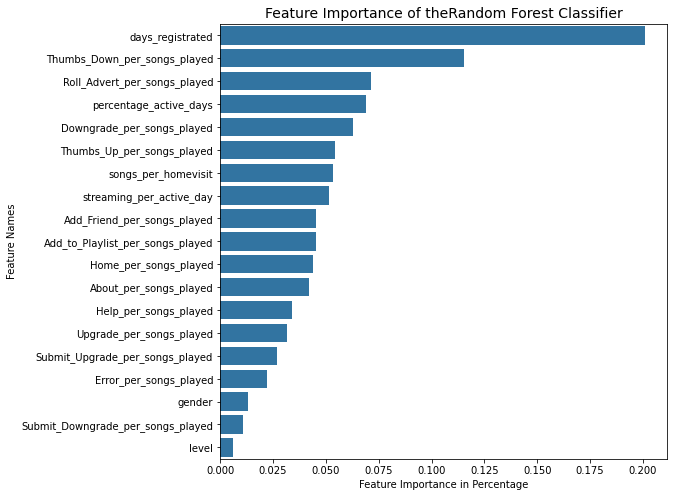

In [181]:
importance_rf_df = create_feature_importance_df(numerical_columns, bestPipeline_rf)
plot_feature_importance(importance_rf_df, 'Random Forest Classifier')

In [152]:
gbt = GBTClassifier()
    
paramGrid_gbt = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 10]) \
        .addGrid(gbt.maxBins, [16, 32, 48]) \
        .addGrid(gbt.maxIter, [10, 20, 30]) \
        .build()  
    
bestPipeline_gbt = find_best_model_paramters(gbt, data_training, data_test, paramGrid_gbt)

F1-score = 72.6523%
Area under ROC = 57.7778%


In [153]:
importance_gbt_df = create_feature_importance_df(numerical_columns, bestPipeline_gbt)
plot_feature_importance(importance_gbt_df, 'Gradient-Boosted Tree Classifier')

,names,importance
15,days_registrated,0.14256
10,About_per_songs_played,0.14176
17,streaming_per_active_day,0.11955
4,Add_to_Playlist_per_songs_played,0.11085
7,Thumbs_Down_per_songs_played,0.09853
18,percentage_active_days,0.08335
3,Thumbs_Up_per_songs_played,0.07466
6,Roll_Advert_per_songs_played,0.05968
8,Downgrade_per_songs_played,0.04368
5,Add_Friend_per_songs_played,0.03606


## 6. Deploy

In [ ]:
# model won't be deployed

In [ ]:
# Write a script to extract the necessary features from the smaller subset of data
# Ensure that your script is scalable, using the best practices discussed in Lesson 3
# Try your script on the full data set, debugging your script if necessary